Build and train a Recurrent Neural Network (RNN) of the type LSTM to predict $X(k)$ and $Y(k)$  as respectively  $\tilde{X(k)}$ an  $\tilde{Y(k)}$ based on inputs

Predictions on testing set are done in [RNN_Sim_StLaurentDeJourdes](RNN_Sim_StLaurentDeJourdes.ipynb)

---

In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf

In [2]:
import joblib

In [3]:
# import pakages forML
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [69]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [71]:
# Each row representing the data of an hour, 
nb_day_2020 = 366 
nb_hour_day = 24 
row2read = nb_day_2020*nb_hour_day # Total number of rows for year 2020

#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'

file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'

# The  commissioning of the Prod P0100 is recent (2022). I upscale the prod P0013 (*10)
# and consider it as that of Prod P0100 and then complete with the real production of P0100 
# for the said year
upscale_factor = 10

# Get files data 
p_mw_0013 = oriFc.readAndReshape_excelFile(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = oriFc.readAndReshape_excelFile(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = oriFc.readAndReshape_excelFile(file_p_inj_0100 ,excel_folder,)



# p_mw_0100_bis = p_mw_0013*upscale_factor
p_mw_prod_bt_total = oriFc.readAndReshape_excelFile(file_prod_bt_total, excel_folder)
p_mw_cons_total = oriFc.readAndReshape_excelFile(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])

# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])

# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select only 2020 and 2021 data
df_prodHT = df_prodHT[df_prodHT.index<='2021 12 31 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2021 12 31 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2021 12 31 23:50']

### Data Cleaning 
See [STLaurentDeJourdes_2](STLaurentDeJourdes_2.ipynb) for a better understanding of what is don ein the following cell

In [72]:
per_index = df_cons_total.index

max_indx = df_cons_total.Cons.argmax()  # Get the indice of the period where the pic occurs
# replace the value with the mean of the previous and following periods
df_cons_total.Cons[max_indx] = (df_cons_total.Cons[max_indx-1] + df_cons_total.Cons[max_indx-1])/2


# Replacing wrong data by the mean of surrounding periods
previous_days = df_cons_total[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_cons_total[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2

# Replacing missing data by the mean of surrondings periods
# Extract previous and following days 
previous_days = df_prodHT.loc[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50'),['P0013','P0018']]
following_days = df_prodHT.loc[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50'),['P0013','P0018']]

# Put the interpolated data into the dataframe
df_prodHT.loc[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50'), ['P0013','P0018']] = (np.array(following_days) + 
                                                                          np.array(previous_days) )/2

# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. Each day total period is therefore given by 10*6
h_start_end = ('07:00','18:50')
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])

#### Plot data

In [73]:
# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1).loc[per_daylight]

# Add categorical data
df_data['Month'] = df_data.index.month
df_data['hour'] = df_data.index.hour

# # Separate training and testing set 
df_train = df_data[df_data.index<'2021 06 01']
df_test = df_data[df_data.index>='2021 06 01']


df_data.Cons[df_data.Cons<=2]=df_data.Cons.mean() # Replace all the periods where 
                                                  # the consumption is lower than 2 MWh by the mean

max_jan = df_data.Cons[df_data.index.month==1].max() # Get the maximum consumption 
                                                     # from the higher consumption month i.e. January
df_data.Cons[df_data.Cons>max_jan]= max_jan   # Replace all the periods where 
                                              # the consumption is higher than max_jan by max_jan


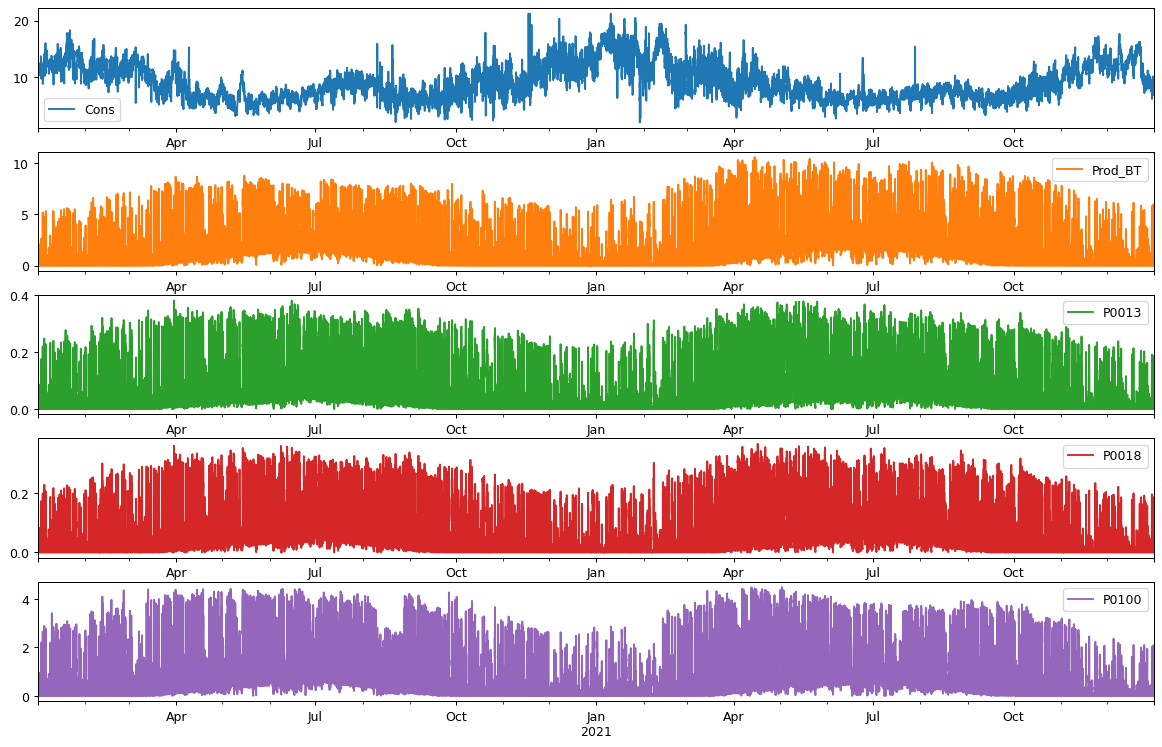

In [75]:
fig, axx = plt.subplots(5,figsize=(16,10),dpi=90)
df_data.iloc[:,:-2].plot(subplots=True,ax=axx);

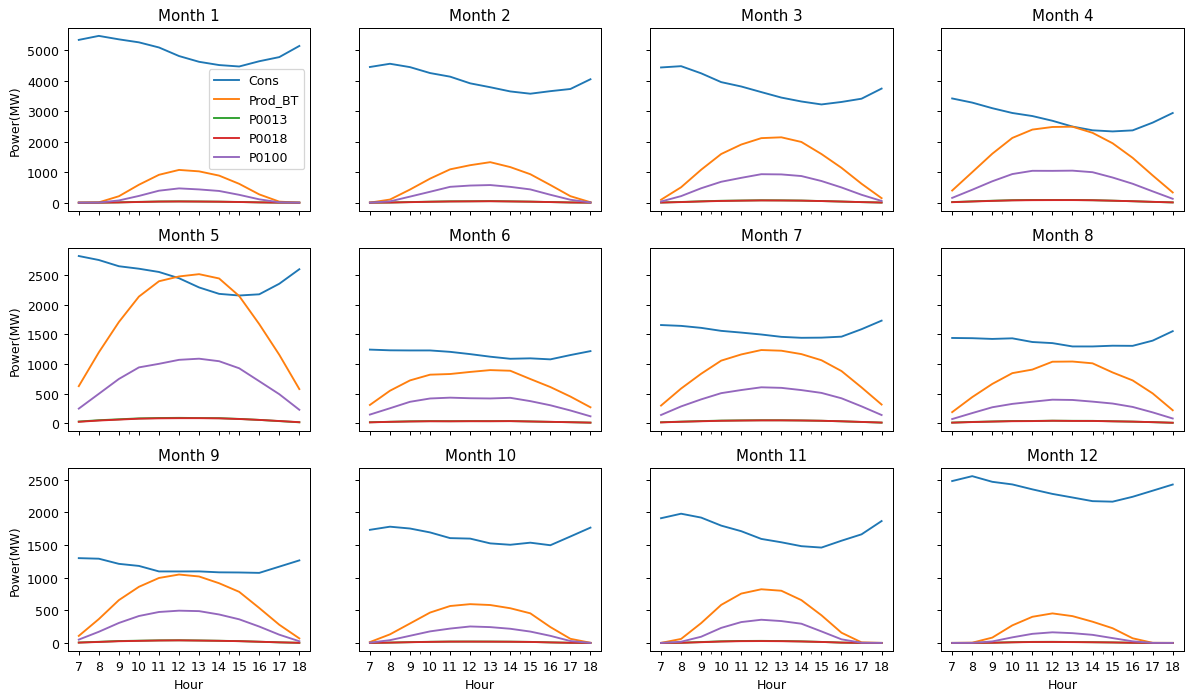

In [76]:
fig, axx = plt.subplots(3,4, figsize=(16,9), dpi=90, sharey='row', sharex=True)
to_plot = df_train.groupby(by=[ 'Month', 'hour'],).sum().groupby(by='Month')

for elm, cur_axx in zip(to_plot, axx.flatten()):
    # Plot legend on the first subplot()
    if elm[0] == 1 :
        elm[1].plot(ax=cur_axx,  xlabel='',ylabel = 'Power(MW)', title=f'Month {elm[0]}')
        var = day_tot_per//6
        # cur_axx.set_xticks(range(0, var), labels=range(7,7+var))
        # cur_axx.semilogy()
    else:    
        elm[1].plot(ax=cur_axx, legend=False, xlabel='Hour', ylabel = 'Power(MW)', title=f'Month {elm[0]}')
        cur_axx.set_xticks(range(0, var), labels=range(7,7+var))
        # cur_axx.set_xticks(range(0,10), labels=range(8,18))
        # cur_axx.semilogy()
        
# fig.tight_layout()

#### Train RNN

In [77]:
from sklearn.compose import ColumnTransformer

In [78]:
# Define Scalers
numerical_scaler = MinMaxScaler()    
categorical_scaler = OneHotEncoder()

n_features = 5
n_catVars = 2    # Total numbers of categorical variables 

# Define types columns  
cat_cols = df_train.columns[-n_catVars:]  # Categorical Column i.e ['Month', Hour]
num_cols = df_train.columns[:-n_catVars]  # Numerical Columns  i.e all others

# Define a prepreocessor
preprocessor = ColumnTransformer([('MinMaxScaler',  numerical_scaler, num_cols) ,
                                  # ('OneHotEncoding', categorical_scaler, cat_cols), 
                                 ])

numerical_scaler.fit(df_train.iloc[:,:-n_catVars])    # Fit trainig set to preprocessor 
# numerical_scaler.fit(df_train.iloc[:,:-n_catVars])    # Fit scaler to the training set 
# categorical_scaler.fit(df_train.iloc[:,-n_catVars:])    # Fit scaler to the training set 

# scaler = load(open())

# Transform training and testing set following the fitting previously donne
train_scaled, test_scaled = map(numerical_scaler.transform,[df_train.iloc[:,:-n_catVars]  , df_test.iloc[:,:-n_catVars]  ] )

##### Define Timeseries  generators


In [79]:
batchSize = 60;
train_generator = TimeseriesGenerator(train_scaled, train_scaled, 
                                      length = day_tot_per, 
                                      batch_size= batchSize)

test_genarator = TimeseriesGenerator(test_scaled, test_scaled, 
                                     length = day_tot_per, 
                                     batch_size= batchSize)

# n_features = len(df_train.columns)  # Define total number of features

##### Defnine the RNN

In [80]:
from tensorflow.keras.optimizers import SGD

In [81]:
rnn_model = Sequential() # Define an emply RNN

# Add first RNN layer
rnn_model.add(LSTM(256, activation='relu', input_shape=(day_tot_per, n_features), return_sequences=True))
rnn_model.add(LSTM(256, activation='relu'))
# rnn_model.add(LSTM(64, activation='relu'))

# Add last Dense layer
rnn_model.add(Dense(n_features, activation='relu'),)


rnn_model.compile(optimizer='adam', loss='mse',metrics=['accuracy'] )

In [82]:
# Define early stoping mecanism to stop training when overfitting start occuring
early_stop = EarlyStopping(monitor= 'val_loss',patience=30, mode='min')

##### Train Model

In [83]:
rnn_model.fit(train_generator, 
          epochs=2, 
          callbacks=[early_stop],
          validation_data=test_genarator,)

Epoch 1/2
620/620 [==============================] - 339s 544ms/step - loss: 0.0113 - accuracy: 0.6564 - val_loss: 0.0063 - val_accuracy: 0.6191
Epoch 2/2
620/620 [==============================] - 342s 551ms/step - loss: 0.0044 - accuracy: 0.7335 - val_loss: 0.0054 - val_accuracy: 0.6008


<AxesSubplot:>

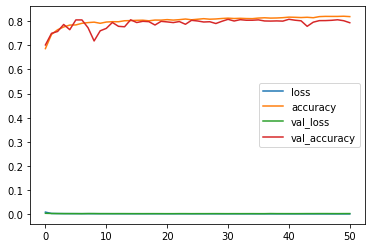

In [20]:
pd.DataFrame(rnn_model.history.history).plot()

In [268]:
# Save model 
# rnn_model.save('pickle_files/RNN/StLaurent_Final')

INFO:tensorflow:Assets written to: pickle_files/RNN/StLaurent_Final\assets


In [269]:
# joblib.dump(numerical_scaler, 'pickle_files/RNN/StLaurent_Final_Scaler.pkl')

['pickle_files/RNN/StLaurent_Final_Scaler.pkl']